In [58]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib

In [59]:
FIRST_SLICE_DATE: datetime = datetime.strptime('8/4/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('01/12/2020', '%d/%m/%Y')

In [60]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [61]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [62]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [63]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [64]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

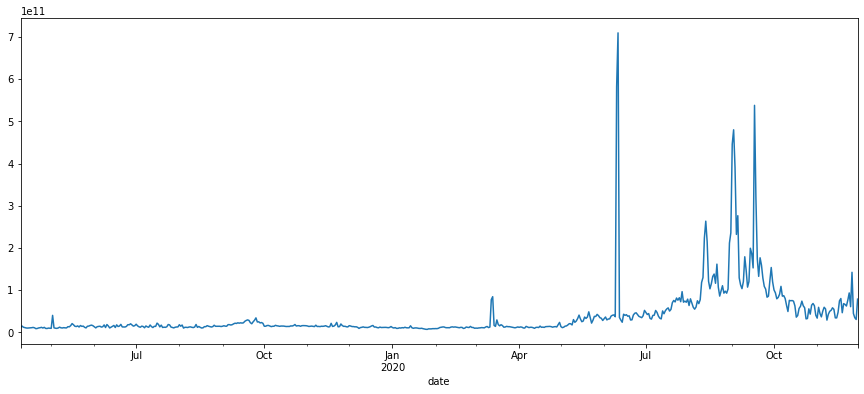

In [65]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [66]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

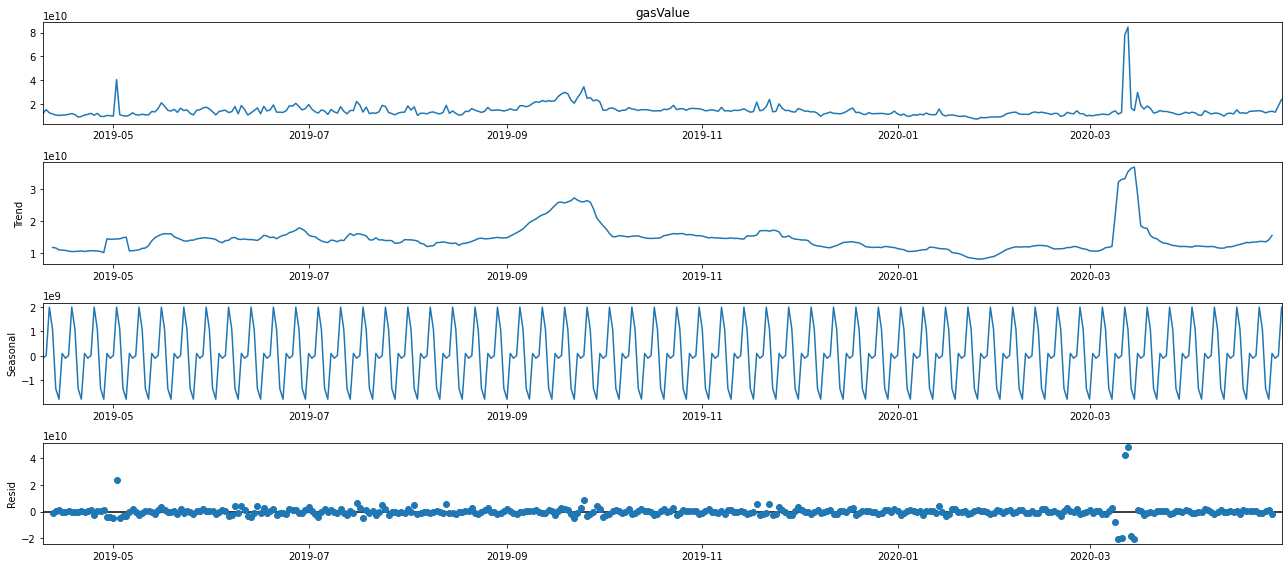

In [67]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition.plot()
plt.show()

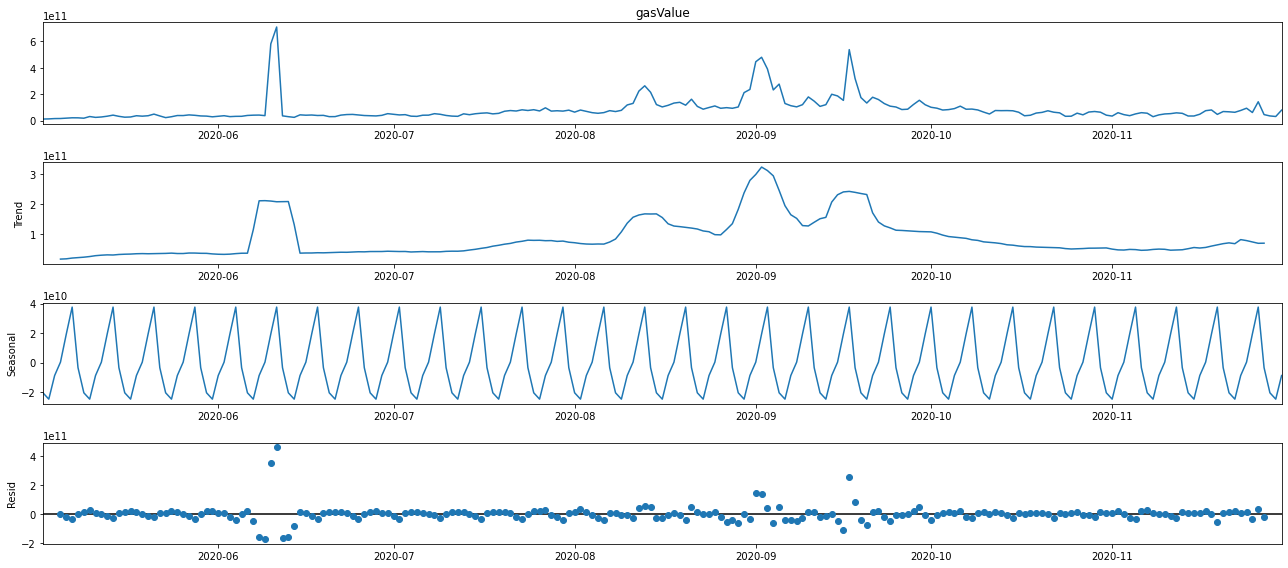

In [68]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition.plot()
plt.show()

Let's apply a log transformation to reduce higher gasValue, and also remove the weekly seasonality.

In [69]:
N = 7
gas_slice1['gasValue'] = gas_slice1['gasValue'] - gas_slice1['gasValue'].shift(N)
gas_slice1.dropna(inplace=True)

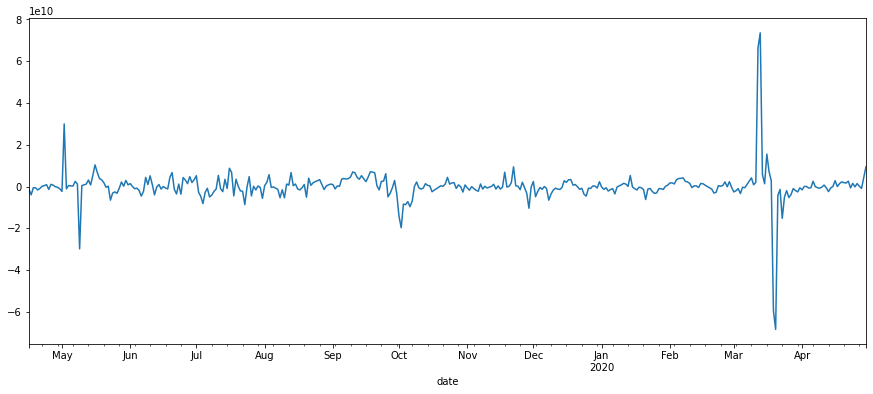

In [70]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [71]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - gas_slice2['gasValue'].shift(N)
gas_slice2.dropna(inplace=True)

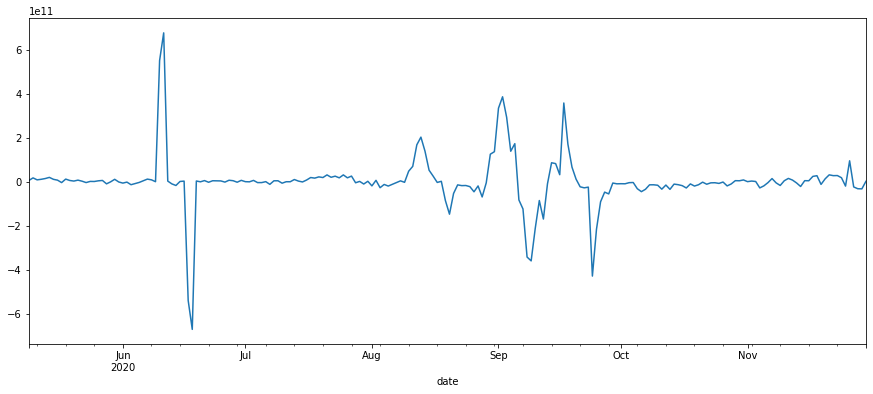

In [72]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [73]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -5.958378e+00
P-Value                 2.067038e-07
# Lags Used             1.500000e+01
# Observations Used     3.650000e+02
Critical Value (1%)    -3.448394e+00
Critical Value (5%)    -2.869491e+00
Critical Value (10%)   -2.571006e+00
dtype: float64


In [74]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.361357
P-Value                   0.000347
# Lags Used              14.000000
# Observations Used     191.000000
Critical Value (1%)      -3.465059
Critical Value (5%)      -2.876794
Critical Value (10%)     -2.574901
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [75]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.019379186889903876
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [76]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.04349122192992605
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In both cases, p-gasValue are greater than 0.05, and "KPSS Statistic" gasValue are less than the critical gasValue. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# DAOstack activity-membership rate series

Let's check the series.

In [77]:
daostack: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daostack_activity_membership_rate.csv'), header=0)
daostack = transform_date_series(df=daostack, date_key='date')

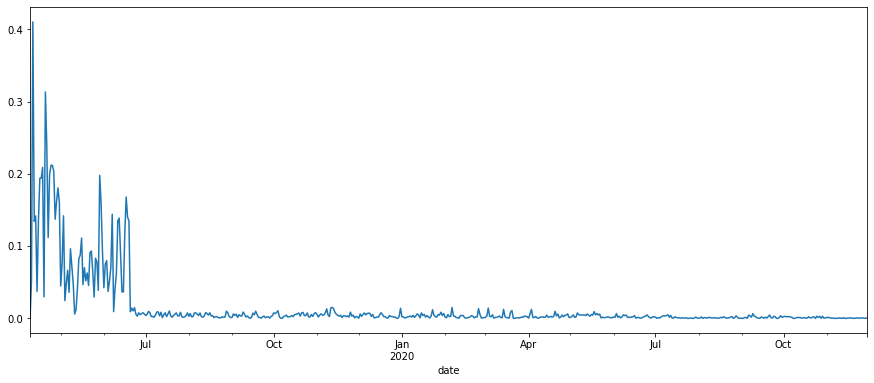

In [78]:
daostack_plot = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_plot['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [79]:
daostack_slice1 = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
daostack_slice2 = filter_series(df=daostack, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

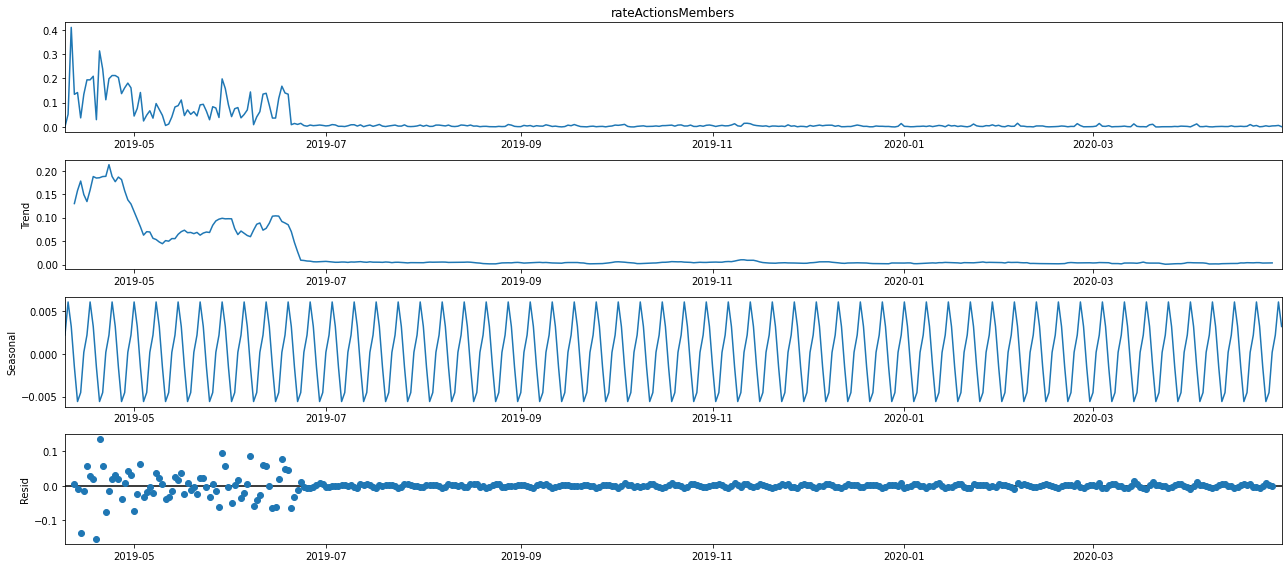

In [80]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=daostack_slice1['rateActionsMembers'], model='additive')
fig = decomposition.plot()
plt.show()

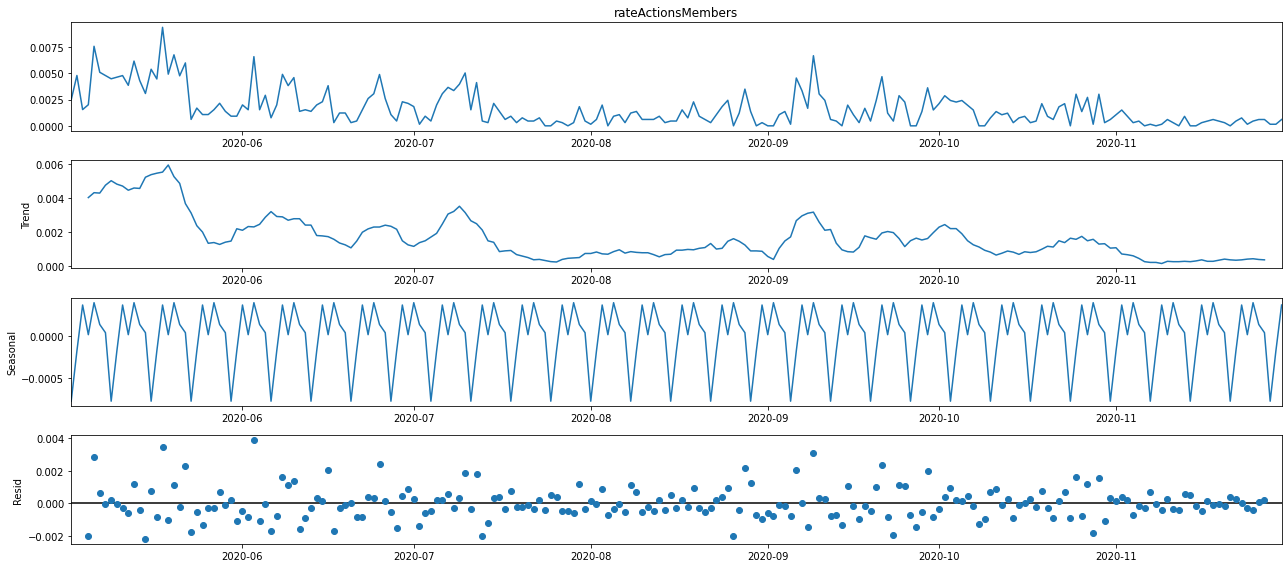

In [81]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=daostack_slice2['rateActionsMembers'], model='additive')
fig = decomposition.plot()
plt.show()

In [82]:
daostack_slice1['rateActionsMembers'] = daostack_slice1['rateActionsMembers'] - daostack_slice1['rateActionsMembers'].shift(N)
daostack_slice1.dropna(inplace=True)

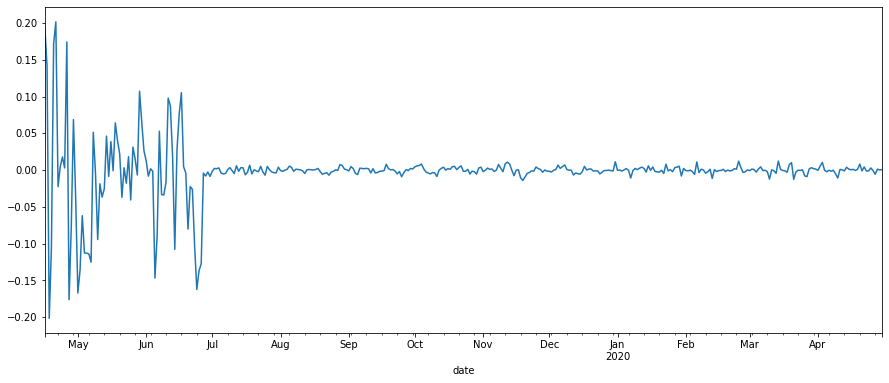

In [83]:
daostack_slice1['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

In [84]:
daostack_slice2['rateActionsMembers'] = daostack_slice2['rateActionsMembers'] - daostack_slice2['rateActionsMembers'].shift(N)
daostack_slice2.dropna(inplace=True)

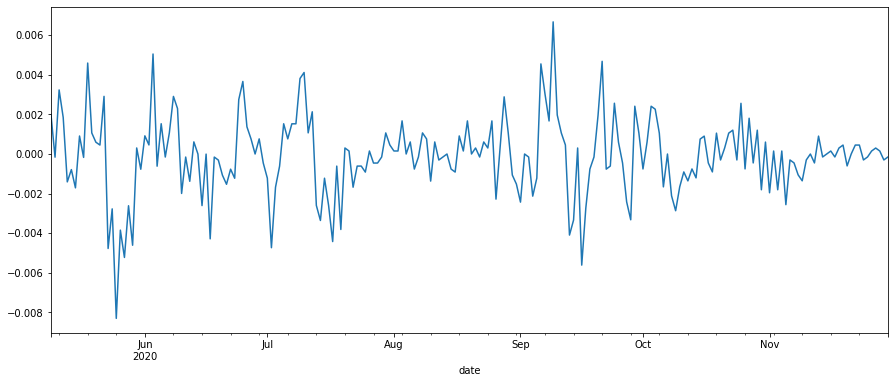

In [85]:
daostack_slice2['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [86]:
print_adf(df=daostack_slice1, key='rateActionsMembers')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.198278
P-Value                   0.000663
# Lags Used              17.000000
# Observations Used     363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64


In [87]:
print_adf(df=daostack_slice2, key='rateActionsMembers')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.302414e+00
P-Value                 1.327978e-10
# Lags Used             1.300000e+01
# Observations Used     1.920000e+02
Critical Value (1%)    -3.464875e+00
Critical Value (5%)    -2.876714e+00
Critical Value (10%)   -2.574859e+00
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical gasValue. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [88]:
print_kpss(df=daostack_slice1, key='rateActionsMembers')

KPSS Statistic: 0.15543227619383354
p-value: 0.1
num lags: 5
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [89]:
print_kpss(df=daostack_slice2, key='rateActionsMembers')

KPSS Statistic: 0.03878532051423381
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both series have gasValue that suggest that we fail to reject H0. So, it is definitely a stationary series.

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [90]:
slice1: pd.DataFrame = pd.DataFrame(
    {'daostack_rate': daostack_slice1['rateActionsMembers'].tolist(),
     'gasPrice': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 8)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0024  , p=0.3174  , df_denom=377, df_num=1
ssr based chi2 test:   chi2=1.0103  , p=0.3148  , df=1
likelihood ratio test: chi2=1.0090  , p=0.3151  , df=1
parameter F test:         F=1.0024  , p=0.3174  , df_denom=377, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3833  , p=0.6819  , df_denom=374, df_num=2
ssr based chi2 test:   chi2=0.7768  , p=0.6781  , df=2
likelihood ratio test: chi2=0.7760  , p=0.6784  , df=2
parameter F test:         F=0.3830  , p=0.6820  , df_denom=374, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1702  , p=0.9165  , df_denom=371, df_num=3
ssr based chi2 test:   chi2=0.5201  , p=0.9145  , df=3
likelihood ratio test: chi2=0.5197  , p=0.9145  , df=3
parameter F test:         F=0.1700  , p=0.9166  , df_denom=371, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3329  , p=0.8558  

In [91]:
slice2: pd.DataFrame = pd.DataFrame(
    {'daostack_rate': daostack_slice2['rateActionsMembers'].tolist(),
     'gasPrice': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4138  , p=0.5208  , df_denom=202, df_num=1
ssr based chi2 test:   chi2=0.4200  , p=0.5170  , df=1
likelihood ratio test: chi2=0.4195  , p=0.5172  , df=1
parameter F test:         F=0.4138  , p=0.5208  , df_denom=202, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7801  , p=0.4598  , df_denom=199, df_num=2
ssr based chi2 test:   chi2=1.5994  , p=0.4495  , df=2
likelihood ratio test: chi2=1.5932  , p=0.4509  , df=2
parameter F test:         F=0.7423  , p=0.4774  , df_denom=199, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6452  , p=0.1803  , df_denom=196, df_num=3
ssr based chi2 test:   chi2=5.1117  , p=0.1638  , df=3
likelihood ratio test: chi2=5.0484  , p=0.1683  , df=3
parameter F test:         F=1.6827  , p=0.1720  , df_denom=196, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5101  , p=0.2008  

# VAR analysis

## Slice 1

In [92]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['rateActionsMembers'] = daostack_slice1['rateActionsMembers'].tolist()

In [93]:
model1 = VAR(slice1)
model1.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,38.58,38.60,5.688e+16,38.59
1,37.97,38.03,3.095e+16,38.00
2,37.93,38.04,2.977e+16,37.97
3,37.88,38.03,2.829e+16,37.94
4,37.85,38.04,2.747e+16,37.93
5,37.84,38.08,2.724e+16,37.94
6,37.74,38.02,2.454e+16,37.85
7,37.52,37.84,1.978e+16,37.65
8,37.45,37.81*,1.839e+16,37.59
9,37.44,37.85,1.828e+16,37.61


In [94]:
results1 = model1.fit(maxlags=8, ic='bic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Jan, 2021
Time:                     21:25:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    38.1773
Nobs:                     373.000    HQIC:                   37.9618
Log likelihood:          -8077.93    FPE:                2.66083e+16
AIC:                      37.8199    Det(Omega_mle):     2.43391e+16
--------------------------------------------------------------------
Results for equation gasValue
                               coefficient          std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                      82466907.175653    310141482.147280            0.266           0.790
L1.gasValue                       0.660867            0.051314           12.879           0.0

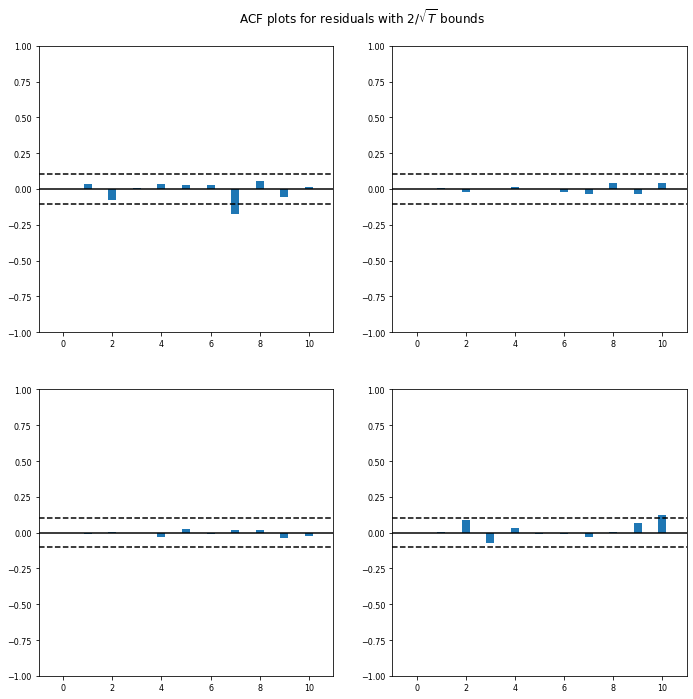

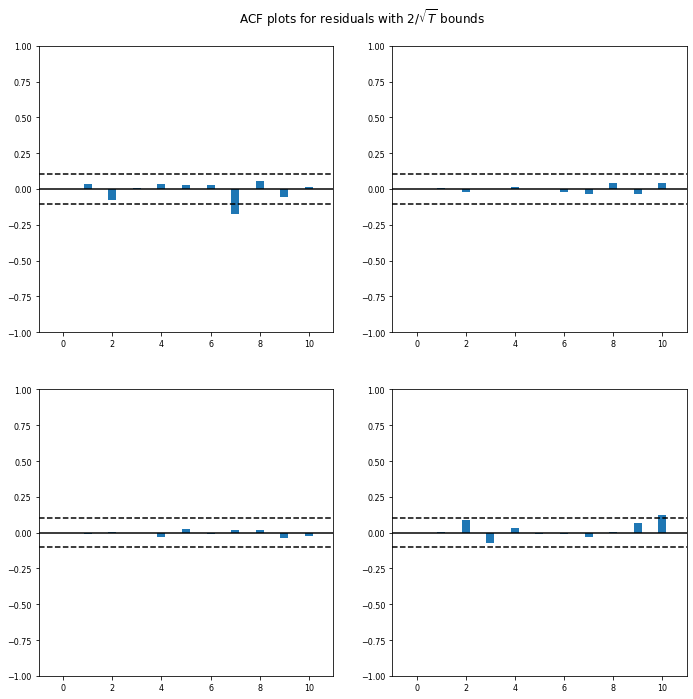

In [95]:
results1.plot_acorr()

### Impulse Response

In [96]:
irf1 = results1.irf(20)

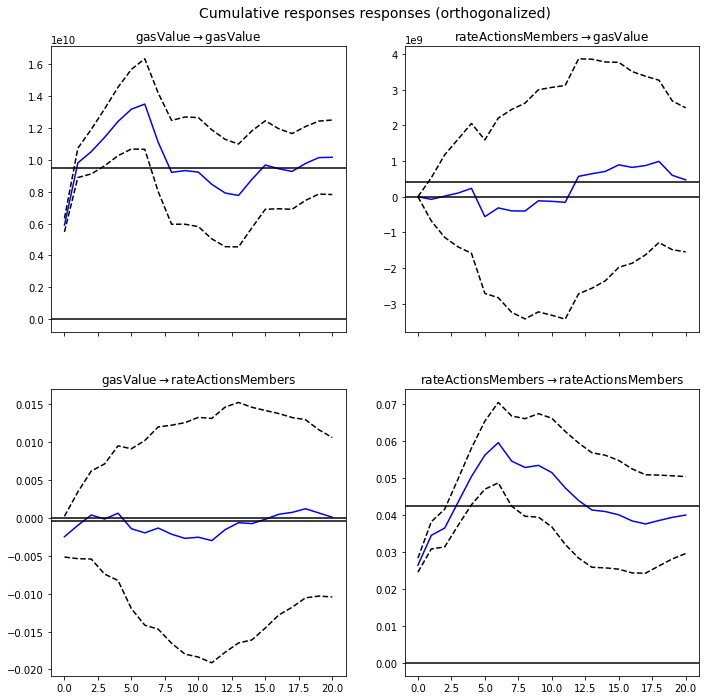

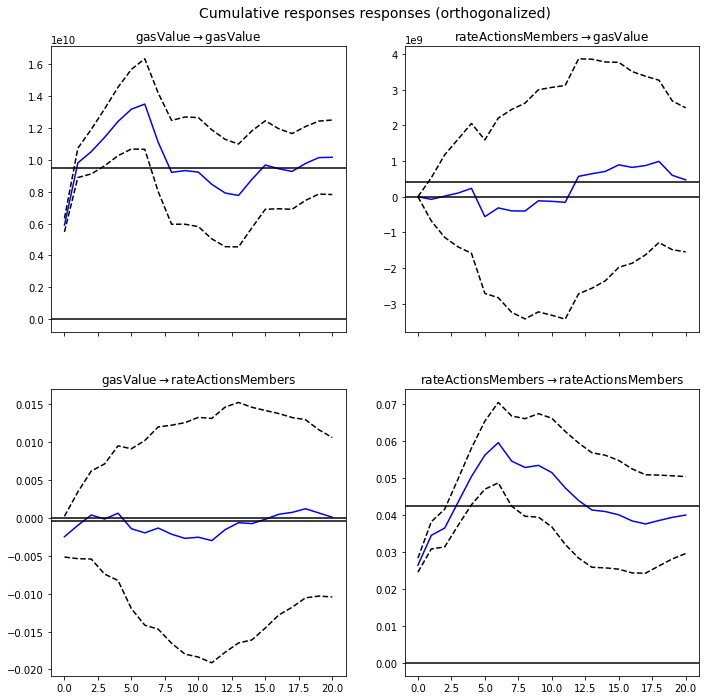

In [97]:
irf1.plot_cum_effects(orth=True)

In [98]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue  rateActionsMembers
0     1.000000            0.000000
1     0.999892            0.000108
2     0.999728            0.000272
3     0.999589            0.000411
4     0.999268            0.000732
5     0.987517            0.012483
6     0.986426            0.013574
7     0.987619            0.012381
8     0.988317            0.011683
9     0.987028            0.012972
10    0.987027            0.012973
11    0.987134            0.012866
12    0.979069            0.020931
13    0.978996            0.021004
14    0.979259            0.020741
15    0.979015            0.020985
16    0.978956            0.021044
17    0.978925            0.021075
18    0.978803            0.021197
19    0.976609            0.023391

FEVD for rateActionsMembers
      gasValue  rateActionsMembers
0     0.008849            0.991151
1     0.010974            0.989026
2     0.013260            0.986740
3     0.012805            0.987195
4     0.012763            0.987237
5     0.

In [99]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
3.973e+04,9.488,0.000,4


In [100]:
results1.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
113.7,65.17,0.000,48


In [101]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
3.272,3.841,0.070,1


## Slice 2

In [102]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['rateActionsMembers'] = daostack_slice2['rateActionsMembers'].tolist()

In [103]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,38.57,38.60,5.623e+16,38.58
1,38.00,38.10,3.180e+16,38.04
2,37.94,38.11,2.989e+16,38.01
3,37.93,38.17,2.969e+16,38.03
4,37.94,38.25,3.007e+16,38.07
5,37.90,38.28,2.888e+16,38.05
6,37.83,38.27,2.691e+16,38.01
7,37.40,37.91,1.754e+16,37.61
8,37.32,37.90*,1.614e+16,37.55
9,37.28,37.92,1.546e+16,37.54


In [104]:
results2 = model2.fit(maxlags=8, ic='bic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Jan, 2021
Time:                     21:25:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    37.9668
Nobs:                     198.000    HQIC:                   37.6307
Log likelihood:          -4230.72    FPE:                1.75359e+16
AIC:                      37.4022    Det(Omega_mle):     1.48724e+16
--------------------------------------------------------------------
Results for equation gasValue
                                 coefficient            std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                      3186859411.826188     5732094730.201344            0.556           0.578
L1.gasValue                         0.685006              0.070765            9.6

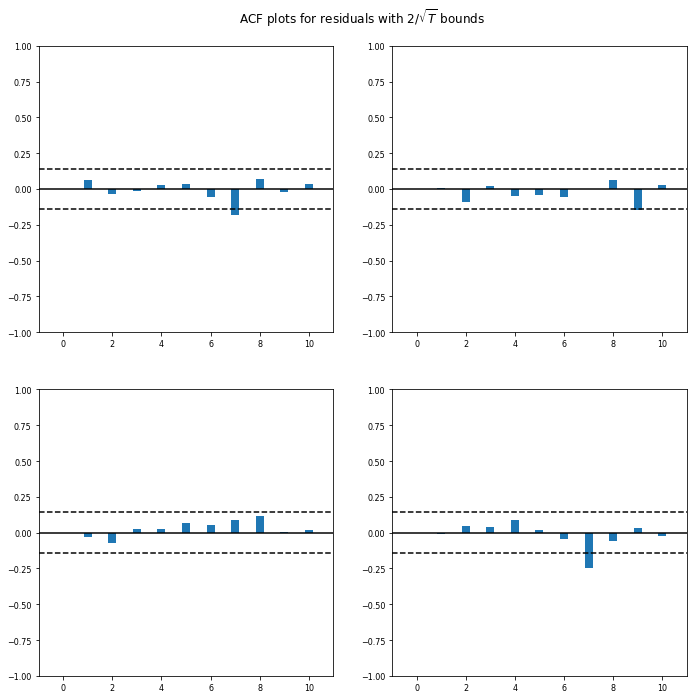

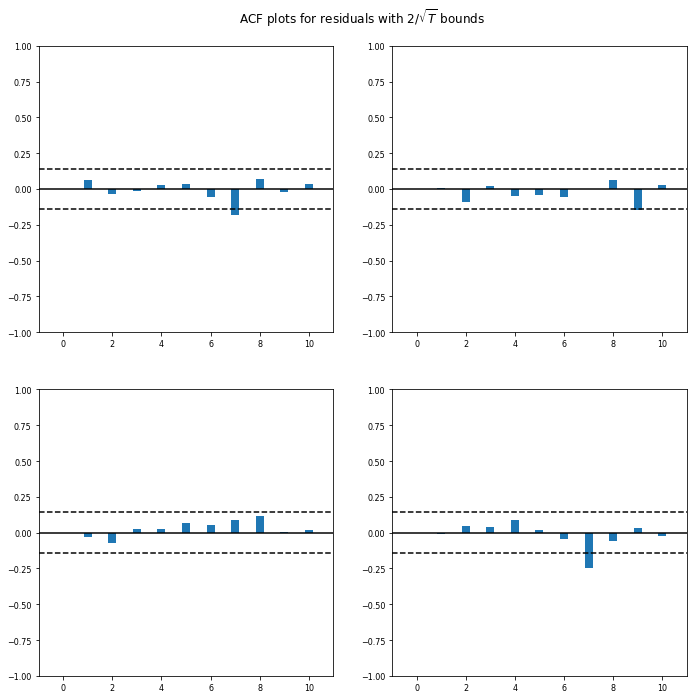

In [105]:
results2.plot_acorr()

### Impulse Response

In [106]:
irf2 = results2.irf(20)

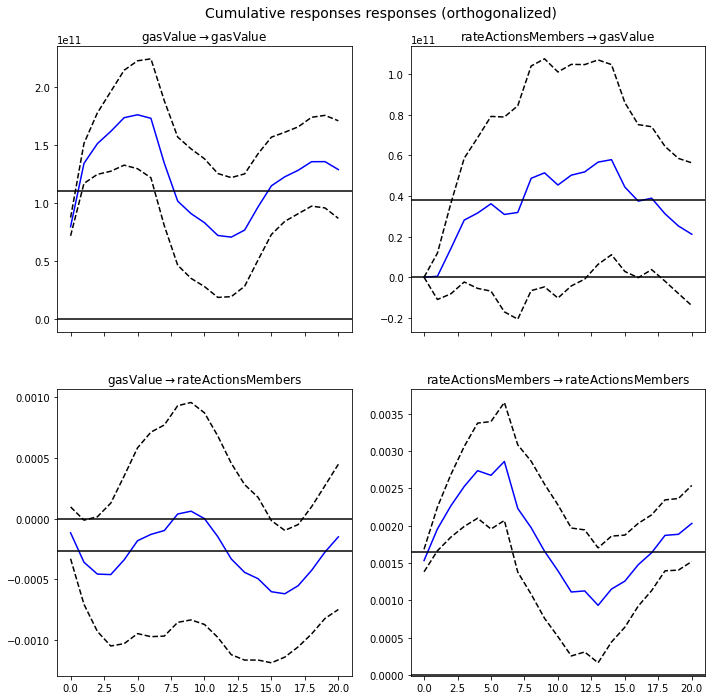

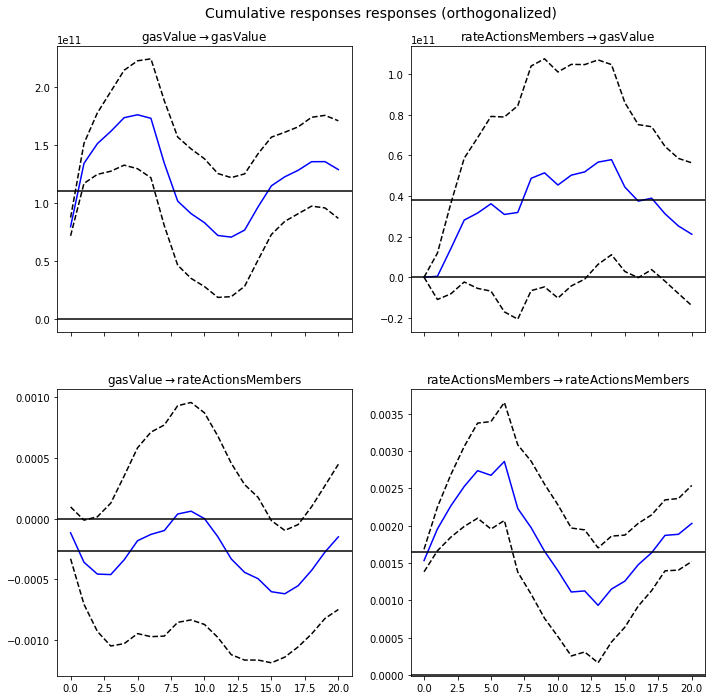

In [107]:
irf2.plot_cum_effects(orth=True)

In [108]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue  rateActionsMembers
0     1.000000            0.000000
1     0.999977            0.000023
2     0.981049            0.018951
3     0.962002            0.037998
4     0.961377            0.038623
5     0.959445            0.040555
6     0.956902            0.043098
7     0.962292            0.037708
8     0.944619            0.055381
9     0.944590            0.055410
10    0.942304            0.057696
11    0.941176            0.058824
12    0.941004            0.058996
13    0.939565            0.060435
14    0.941181            0.058819
15    0.930674            0.069326
16    0.927900            0.072100
17    0.927920            0.072080
18    0.924448            0.075552
19    0.922208            0.077792

FEVD for rateActionsMembers
      gasValue  rateActionsMembers
0     0.005922            0.994078
1     0.028027            0.971973
2     0.030471            0.969529
3     0.029731            0.970269
4     0.034344            0.965656
5     0.

In [109]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
913.6,9.488,0.000,4


In [110]:
results2.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
101.7,65.17,0.000,48


In [111]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.166,3.841,0.280,1
